In [2]:
# Importación de librerías necesarias
import os
import cv2 # OpenCV: para procesamiento de imágenes
import numpy as np
import random
from itertools import combinations
import matplotlib.pyplot as plt # Para graficar imágenes y resultados

In [3]:
# Importación de módulos de Keras necesarios para construir el modelo de red neuronal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

In [ ]:
# Fijar la semilla para asegurar la reproducibilidad de los resultados
SEED = 42
random.seed(SEED) # Semilla para funciones aleatorias estándar
np.random.seed(SEED) # Semilla para funciones aleatorias de NumPy

In [ ]:
# Definir tamaño de las imágenes a usar y la ruta al conjunto de datos
IMG_SIZE = (200, 150)  # Tamaño (ancho x alto) para redimensionar imágenes con cv2.resize
DATASET_DIR = "./resources"

In [ ]:
# Función para cargar el conjunto de datos desde un directorio
def load_dataset(dataset_dir, size=IMG_SIZE):
    data = []
    person_dirs = sorted(os.listdir(dataset_dir))

    for idx, person in enumerate(person_dirs):
        person_path = os.path.join(dataset_dir, person)
        if os.path.isdir(person_path):
            images = []
            for fname in os.listdir(person_path):
                try:
                    fpath = os.path.join(person_path, fname)
                    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE) # Leer imagen en escala de grises
                    if img is None:
                        raise Exception("Imagen no válida")
                    img = cv2.resize(img, size)
                    img = img.astype("float32") / 127.5 - 1.0  # Escalado a [-1, 1]
                    img = np.expand_dims(img, axis=-1)  # Añadir dimensión de canal (necesario para redes CNN)
                    images.append((img, idx, person))
                except Exception as e:
                    print(f"Error cargando {fpath}: {e}")
            if len(images) >= 2:
                data.append(images)
    return data

In [ ]:
# Función para generar pares de imágenes (positivos y negativos) a partir del dataset
def generate_pairs(data, num_negatives_per_positive=1):
    pairs = []
    labels = []
    meta_info = []
    num_classes = len(data)

    for i, person_imgs in enumerate(data):
        for (img1, idx1, name1), (img2, idx2, name2) in combinations(person_imgs, 2):
            pairs.append([img1, img2]) # Par positivo
            labels.append(1) # Etiqueta 1 (misma persona)
            meta_info.append(((idx1, name1), (idx2, name2)))

            for _ in range(num_negatives_per_positive):
                while True:
                    j = random.randint(0, num_classes - 1)
                    if j != i:
                        break
                img_neg, idx_neg, name_neg = random.choice(data[j])
                pairs.append([img1, img_neg]) # Par negativo
                labels.append(0) # Etiqueta 0 (personas distintas)
                meta_info.append(((idx1, name1), (idx_neg, name_neg)))

    return np.array(pairs), np.array(labels), meta_info

In [ ]:
# Función para mostrar visualmente un par de imágenes con su etiqueta y metadatos
def show_pair(img1, img2, label, meta):
    (idx1, name1), (idx2, name2) = meta
    fig, ax = plt.subplots(1, 2)
    
    # Mostramos la primera imagen en escala de grises
    ax[0].imshow(img1.squeeze(), cmap="gray")
    ax[0].set_title(f"{name1} (#{idx1})")
    
    # Mostramos la segunda imagen en escala de grises 
    ax[1].imshow(img2.squeeze(), cmap="gray")
    ax[1].set_title(f"{name2} (#{idx2})")
    
    # Título general que indica si las imágenes son de la misma persona o no ✅
    plt.suptitle(f"Etiqueta: {'Iguales' if label == 1 else 'Diferentes'}")
    plt.show()

In [1]:
# Carga del conjunto de datos
print("📂 Cargando dataset...")
data = load_dataset(DATASET_DIR)

print("🔧 Generando pares de entrenamiento...")
pairs, labels, meta_info = generate_pairs(data)

# Separar las imágenes de entrada en dos arreglos distintos: X1 y X2
# Cada par es una lista [img1, img2], así que extraemos cada componente
X1 = np.array([pair[0] for pair in pairs])
X2 = np.array([pair[1] for pair in pairs])
y = np.array(labels) # Etiquetas correspondientes (1 para igual, 0 para diferente)

print(f"✅ Listo. Pares generados: {len(pairs)} - Etiquetas: {len(labels)}")
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")

📂 Cargando dataset...


NameError: name 'load_dataset' is not defined

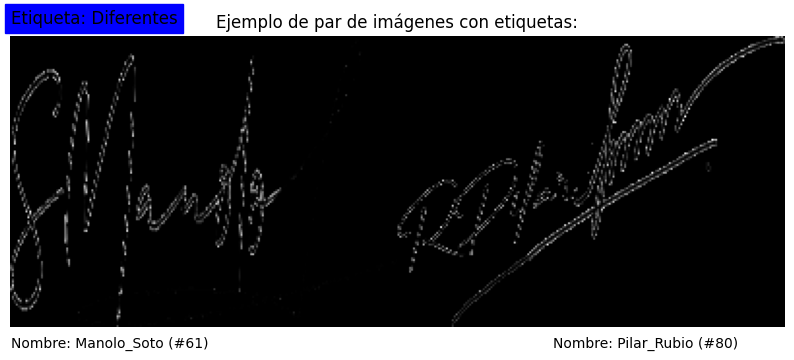

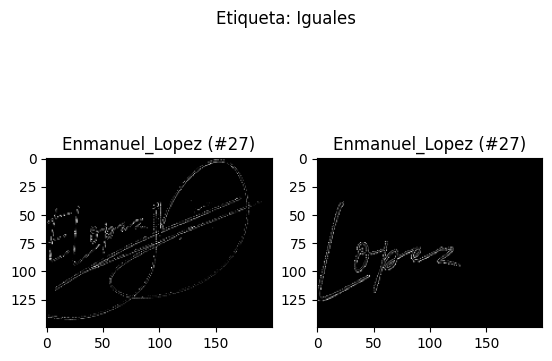

In [87]:
# Mostrar un par de imágenes con etiquetas:
plt.figure(figsize=(10, 5))
plt.axis("off")
valor = random.randint(0, len(X1) - 1)
plt.title("Ejemplo de par de imágenes con etiquetas:")
plt.imshow(np.hstack([X1[valor].squeeze(), X2[valor].squeeze()]), cmap="gray")
plt.text(0, -7, f"Etiqueta: {'Iguales' if y[valor] == 1 else 'Diferentes'}", fontsize=12, color='black', backgroundcolor='blue')
plt.text(0, 160, f"Nombre: {meta_info[valor][0][1]} (#{meta_info[valor][0][0]})", fontsize=10, color='black', backgroundcolor='white')
plt.text(280, 160, f"Nombre: {meta_info[valor][1][1]} (#{meta_info[valor][1][0]})", fontsize=10, color='black', backgroundcolor='white')
plt.show()



# Mostrar un par de imágenes con etiquetas
i = random.randint(0, len(X1) - 1)
show_pair(X1[i], X2[i], y[i], meta_info[i])


In [24]:
def siamese_model(input_shape=(150, 200, 1)):  # alto, ancho, canal
    input_img = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    embedding = Dense(128)(x)
    return Model(inputs=input_img, outputs=embedding)

def euclidean_distance(vects):
    (feats1, feats2) = vects
    sum_squared = K.sum(K.square(feats1 - feats2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [25]:
# Modelo base y siamese
base_model = siamese_model(input_shape=(150, 200, 1))
input_a = Input(shape=(150, 200, 1))
input_b = Input(shape=(150, 200, 1))

embedding_a = base_model(input_a)
embedding_b = base_model(input_b)
distance = Lambda(euclidean_distance)([embedding_a, embedding_b])


In [26]:
siamese_net = Model(inputs=[input_a, input_b], outputs=distance)

# Compilar
siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

siamese_net.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 150, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 150, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 128)       │ 245,814,2… │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_3[0][… │
│                     │                   │            │ functional_3[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,814,208 (937.71 MB)

 Trainable params: 245,814,208 (937.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento
history = siamese_net.fit(
    [X1, X2], y,
    batch_size=8,
    epochs=10,
    validation_split=0.2
)

In [ ]:
# Visualización de métricas
plt.figure(figsize=(12, 5))

In [ ]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

In [ ]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

In [ ]:
plt.tight_layout()
plt.show()